In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./Data"))

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'PUBG_Finish_Placement_Prediction', 'PUBG_Player_Statistics']


In [2]:
dataset = pd.read_csv("./Data/PUBG_Finish_Placement_Prediction/train.csv")
test_set = pd.read_csv("./Data/PUBG_Finish_Placement_Prediction/test.csv")
dataset.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217



**Group Experience**

> *If the same group of players plays in different matches, they will have a different groupId each time.*

Possibly interesting concept: Number of matches played within a group and aggregations based of group history.

If groupId was kept consistent across matches we can essentially track the group's history and experience playing together.

Sadly, it seems like groupIds are only used for a match so cross-match tracking is not possible as is.

If the player IDs it might be beneficial to try to generate our own group Id's that actually mean something.

In [3]:
match_amount = len(dataset.matchId.unique())
print('Number of matches in the dataset: %d' % match_amount)
group = dataset.groupby("groupId")['matchId'].nunique()
group[group > 1]

Number of matches in the dataset: 47734


Series([], Name: matchId, dtype: int64)

**Separating game modes**

> *The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.*

First things first, we need to fix the game mode problem. In this dataset group sizes vary from 1 to just under 100. 

These game modes are fundamentally different specially those nearing 100 players as it likely is a 'zombie mode' match.

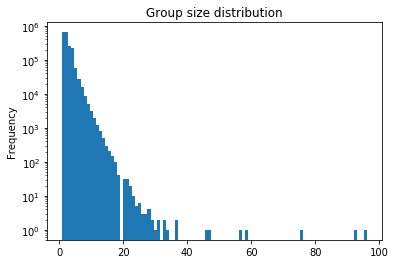

In [4]:
group_size = dataset.groupby(["matchId","groupId"])['Id'].nunique()
group_size.plot(kind='hist', logy = True, title='Group size distribution', bins=100)

Diferent game modes by squad size:

Solo - Only 1 player groups allowed
Duo - Only two player groups allowed
Squad - Between 2 and 4 player groups
Custom - Anything goes. Several different game modes like zombies or 20vs.


In [5]:
matches = group_size.reset_index().matchId.unique()
not_solo_matches = group_size[group_size != 1].reset_index().matchId.unique()
solo_matches = np.setdiff1d(matches, not_solo_matches)
solo_matches_amount = len(solo_matches)
#not_solo_matches = pd.Series(not_solo_matches)
print('Number of matches in the dataset: %d' % match_amount)
print('Number of solo matches in the dataset: %d' % solo_matches_amount)
print('Percentage of solo matches in the dataset: %f%%' % ((solo_matches_amount/match_amount)*100))

Number of matches in the dataset: 47734
Number of solo matches in the dataset: 524
Percentage of solo matches in the dataset: 1.097750%


In [6]:
not_duo_matches = group_size[group_size != 2].reset_index().matchId.unique()
duo_matches = np.setdiff1d(matches, not_duo_matches)
duo_matches_amount = len(duo_matches)
#not_duo_matches = pd.Series(not_duo_matches)
print('Number of matches in the dataset: %d' % match_amount)
print('Number of duo matches in the dataset: %d' % duo_matches_amount)
print('Percentage of duo matches in the dataset: %f%%' % ((duo_matches_amount/match_amount)*100))

Number of matches in the dataset: 47734
Number of duo matches in the dataset: 180
Percentage of duo matches in the dataset: 0.377090%


In [7]:
not_squad_matches = group_size[group_size >= 5].reset_index().matchId.unique()
squad_matches = np.setdiff1d(np.setdiff1d(np.setdiff1d(matches, not_squad_matches), duo_matches),solo_matches)
squad_matches_amount = len(squad_matches)
print('Number of matches in the dataset: %d' % match_amount)
print('Number of squad matches in the dataset: %d' % squad_matches_amount)
print('Percentage of squad matches in the dataset: %f%%' % ((squad_matches_amount/match_amount)*100))

Number of matches in the dataset: 47734
Number of squad matches in the dataset: 15737
Percentage of squad matches in the dataset: 32.968115%


In [8]:
custom_matches = np.setdiff1d(np.setdiff1d(np.setdiff1d(matches, squad_matches), duo_matches),solo_matches)
#not_squad_matches = np.setdiff1d(groupsize.reset_index().matchID.unique(), custom_matches)
custom_matches_amount = len(custom_matches)
print('Number of matches in the dataset: %d' % match_amount)
print('Number of custom matches in the dataset: %d' % custom_matches_amount)
print('Percentage of custom matches in the dataset: %f%%' % ((custom_matches_amount/match_amount)*100))

Number of matches in the dataset: 47734
Number of custom matches in the dataset: 31293
Percentage of custom matches in the dataset: 65.557045%


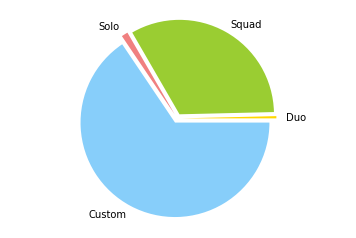

In [9]:
labels = 'Duo', 'Squad', 'Solo' ,'Custom'
sizes = [duo_matches_amount, squad_matches_amount, solo_matches_amount, custom_matches_amount]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.05, 0.05, 0.05, 0.05)
plt.pie(sizes, labels=labels, explode=explode, colors=colors)
plt.axis('equal')
plt.show()

**Game Mode as a categorical value**

We will now add the game mode to the entry to allow the model to learn the difference among game types. 
To this end we will encode the mode as a one-hot vector so it plays nicely with XGboost and ANNs. 

In [10]:
solo = set(solo_matches)
duo = set(duo_matches)
squad = set(squad_matches)
custom = set(custom_matches)

def one_hot_game_mode(Id, solo, duo, squad, custom):
    return int(Id in solo), int(Id in duo), int(Id in squad), int(Id in custom)

dataset['solo'] = 0
dataset['duo'] = 0
dataset['squad'] = 0
dataset['custom'] = 0
dataset[['solo','duo','squad','custom']] = pd.DataFrame(elem for elem in dataset.matchId.apply(one_hot_game_mode,args=(solo,duo,squad,custom)))

dataset.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,solo,duo,squad,custom
0,0,24,0,0,5,247.30,2,0,4,17,...,0,0,782.40,4,1458,0.8571,0,0,0,1
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0,119.60,3,1511,0.0400,0,0,0,1
2,2,878242,2,0,1,93.73,1,0,2,54,...,0,0,3248.00,5,1583,0.7407,0,0,0,1
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0,21.49,1,1489,0.1146,0,0,1,0
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0,640.80,4,1475,0.5217,0,0,0,1


**Feature Scaling**

The scale of some of these values are very different and might lead to problems down the line with some machine learning algorithms so we perform min-max normalisation.

This won't affect the performance of tree estimators like XGBoost or Random Forest but it is known to increase performance of gradient based machine learning methods. 

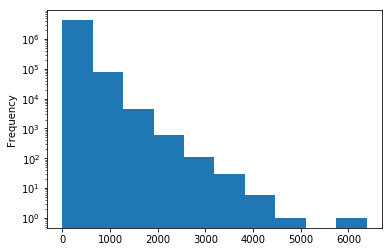

In [11]:
dataset.damageDealt.plot(kind='hist', logy=True)

In [38]:
norm_list = ["winPoints","killPoints","damageDealt","rideDistance","walkDistance", "swimDistance", "longestKill"]
dataset[norm_list] =(dataset[norm_list] - dataset[norm_list].mean())/(dataset[norm_list].max() - dataset[norm_list].min())
test_set[norm_list] =(test_set[norm_list] - dataset[norm_list].mean())/(dataset[norm_list].max() - dataset[norm_list].min())
#train.killPoints =(train.winPoints-train.winPoints.mean())/(train.winPoints.max() - train.winPoints.min())
train.winPoints.plot(kind='hist', logy=True)
train.walkDistance.plot(kind='hist', logy=True)

NameError: name 'train' is not defined

**Correlation Matrix**

The main correlators with success include:

1. Walking distance
2. Number of boosts
3. Number of weapons acquired

These all correlate with playtime as someone who plays for longer will end up walking more, getting more boosts (which increase life points over the cap) and acquiring more weapons.

Interestingly winPoints doesn't  correlate strongly with actually winning 

In [12]:
print('Correlation with winPlacePerc')
correlation_matrix = dataset.corr()
correlation_matrix.winPlacePerc.sort_values(ascending=False)

Correlation with winPlacePerc


winPlacePerc       1.000000
walkDistance       0.811857
boosts             0.618075
weaponsAcquired    0.571521
damageDealt        0.438552
heals              0.427986
kills              0.415350
longestKill        0.405800
killStreaks        0.372546
assists            0.304642
rideDistance       0.301220
DBNOs              0.279475
headshotKills      0.278705
revives            0.251399
winPoints          0.170407
swimDistance       0.154889
killPoints         0.090293
vehicleDestroys    0.057700
squad              0.038586
numGroups          0.035831
maxPlace           0.034235
roadKills          0.028879
solo               0.009352
duo                0.005102
matchId            0.000423
groupId           -0.000239
teamKills         -0.006122
Id                -0.018157
custom            -0.040803
killPlace         -0.708314
Name: winPlacePerc, dtype: float64

**Data Augmentation**

Another PUBG statistics dataset is available on Kaggle, let's see if we can obtain any useful insights.

The data contained in the dataset is comprised of 150 diferent data points pertaining to the top-players at the time of collection. 

This might prove be an issue down the line as, in my experience, the average player isn't very good. So the data might be fundamentally different depending on the sample collected. 


Another possible concern is that the data contained was collected over a year ago. This, however, should prove a non-issue as anyone familiar with the game can testify all of the development efforts have gone into sketchy monetization and not gameplay, so the meta-game should still be pretty similar.

In [13]:
aug_dataset = pd.read_csv("./Data/PUBG_Player_Statistics/PUBG_Player_Statistics.csv")
print(str(aug_dataset.columns.values))

['player_name' 'tracker_id' 'solo_KillDeathRatio' 'solo_WinRatio'
 'solo_TimeSurvived' 'solo_RoundsPlayed' 'solo_Wins' 'solo_WinTop10Ratio'
 'solo_Top10s' 'solo_Top10Ratio' 'solo_Losses' 'solo_Rating'
 'solo_BestRating' 'solo_DamagePg' 'solo_HeadshotKillsPg' 'solo_HealsPg'
 'solo_KillsPg' 'solo_MoveDistancePg' 'solo_RevivesPg' 'solo_RoadKillsPg'
 'solo_TeamKillsPg' 'solo_TimeSurvivedPg' 'solo_Top10sPg' 'solo_Kills'
 'solo_Assists' 'solo_Suicides' 'solo_TeamKills' 'solo_HeadshotKills'
 'solo_HeadshotKillRatio' 'solo_VehicleDestroys' 'solo_RoadKills'
 'solo_DailyKills' 'solo_WeeklyKills' 'solo_RoundMostKills'
 'solo_MaxKillStreaks' 'solo_WeaponAcquired' 'solo_Days'
 'solo_LongestTimeSurvived' 'solo_MostSurvivalTime' 'solo_AvgSurvivalTime'
 'solo_WinPoints' 'solo_WalkDistance' 'solo_RideDistance'
 'solo_MoveDistance' 'solo_AvgWalkDistance' 'solo_AvgRideDistance'
 'solo_LongestKill' 'solo_Heals' 'solo_Revives' 'solo_Boosts'
 'solo_DamageDealt' 'solo_DBNOs' 'duo_KillDeathRatio' 'duo_WinRati

As we lack the convinient WinPlacePerc variable in our augmentation dataset what we will do is compare everything but that.

The plan is that for every player we would be able to assign the closest player in the augmented dataset and hence have an increased number of data points. This may or may not be useful.

First we need a way to convert our augmented data to look like our normal data.

Example:

Depending on our group size (Solo, Duo, Squad) we will look at diferent parts of the dataframe in order to make an apples to apples comparison. 

There are some big squads in this 

**XGBoost baseline**

XGboosting is a resilient tree-bosting machine learning algorithm known for being robust in these type of datasets without needing of a lot of pre-processing.

In [14]:
dataset.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,solo,duo,squad,custom
0,0,24,0,0,5,247.30,2,0,4,17,...,0,0,782.40,4,1458,0.8571,0,0,0,1
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0,119.60,3,1511,0.0400,0,0,0,1
2,2,878242,2,0,1,93.73,1,0,2,54,...,0,0,3248.00,5,1583,0.7407,0,0,0,1
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0,21.49,1,1489,0.1146,0,0,1,0
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0,640.80,4,1475,0.5217,0,0,0,1


In [15]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, nthread=-1)

dataset_labels = dataset.pop('winPlacePerc')
dataset = dataset.drop(['Id','groupId','matchId'], axis=1)
test_set = test_set.drop(['Id','groupId','matchId'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_labels ,test_size=0.2)
#test = pd.read_csv("../input/test.csv")

xgb.fit(X_train,y_train, eval_metric='rmse', verbose=True)

predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))
print(mean_squared_error(predictions,y_test))


0.9067381626650243
0.0079777574099164


In [16]:
pred = xgb.predict(test_set)
print(pred)
test = pd.read_csv("../input/sample_submission.csv")
test['winPlacePerc'] = pd.Series(pred)
test.to_csv("./submission.csv")

ValueError: feature_names mismatch: ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'solo', 'duo', 'squad', 'custom'] ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']
expected custom, solo, squad, duo in input data



Now we know which matches belong to which game modes we will split the model in three and evaluate its performance.

